## **Evaluating Clustering Methods for Ticket Subclustering**

This notebook focuses on evaluating the quality of different clustering algorithms (**KMeans**, **BIRCH**, and **Agglomerative Clustering**) when applied to subclustering issue summaries from support tickets.

We use sentence embeddings generated by the `all-mpnet-base-v2` model to represent ticket summaries in vector space. For each parent cluster of tickets, we apply dimensionality reduction and then assess how well each clustering method separates the data.

### **Objectives**
- Compare clustering quality using **Silhouette Score**, **Calinski-Harabasz Index (CHI)**, and **Davies-Bouldin Index (DBI)**
- Identify the best-performing method per parent cluster
- Visualize subcluster separation and distribution for each algorithm

This evaluation helps determine which method is most effective for uncovering coherent subtopics in support ticket datasets.


## **Setup and Configuration**
* Mount Google Drive (if using Colab)
* Import required libraries
* Define configuration variable (data source)

In [1]:
# Mount to Google Drive (Google Colab only)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Import Libraries
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans, AgglomerativeClustering, Birch
from sklearn.decomposition import PCA
from sklearn.metrics import calinski_harabasz_score, silhouette_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler
import umap
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [3]:
# Define global configuration variables
ticket_src = "tdx"  # Set to "tdx" or "anvil" depending on data source

## **Load and Prepare Data**
* Load ticket summaries and cluster assignments
* Merge datasets
* Drop unnecessary columns
* View and verify the merged dataset

In [4]:
# Load and merge ticket and cluster data

# Read ticket summaries and their cluster assignments
df_tickets = pd.read_csv(f'/content/drive/MyDrive/Colab Notebooks/TicketHub/{ticket_src}_ticket_summaries.csv')
df_clusters = pd.read_csv(f'/content/drive/MyDrive/Colab Notebooks/TicketHub/{ticket_src}_clusters.csv')

# Merge the two datasets on the 'issuenumber' field to combine clustering and summary data
df_merged = pd.merge(df_clusters, df_tickets, on='issuenumber', how='inner')

# Remove unnecessary fields such as title and stopword-free title
df_merged = df_merged.drop(['title', 'titlenostopwords'], axis=1)


In [5]:
df_merged.head()

,issuenumber,cluster,clustername,issue_summary,resolution
0,448,10,"gilbreth, cluster, node, nodes","Jobs are being delayed in the pending queue, s...",The delay in job start is due to SLURM trying ...
1,1150,2,"python, software, installation, install",User is unable to install Python packages in a...,"To resolve this issue, the user should follow ..."
2,2345,5,"gpu, gpus, gb, nvidia",User needs a quote for purchasing four A100 GP...,The vendor is currently obtaining a quote for ...
3,3248,4,"rcac, purchase, ticket, dear",User cannot log into Gilbreth GPU access on Wi...,The user needs to use Purdue two-factor authen...
4,3249,5,"gpu, gpus, gb, nvidia",User is unable to log into Gilbreth GPU cluste...,"To resolve this issue, users should confirm th..."


In [6]:
# Create a dataframe that tallies the number of tickets per parent cluster
cluster_counts = df_merged['cluster'].value_counts()

## **Load Sentence Embedding Model and Define Visualization/Clustering Utilities**
- Load `all-mpnet-base-v2` with GPU support for encoding ticket summaries
- Define functions for parent cluster visualization and determining the optimal `k`

In [7]:
# Load sentence embedding model (with GPU support)
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2', device='cuda')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [33]:
# Visualize subclusters per each parent cluster
def visualize_subclusters(embeddings, labels, cluster_name):
    # Reduce embeddings to 2 dimensions for visualization purposes only
    reducer = umap.UMAP(n_components=2, random_state=42)
    reduced = reducer.fit_transform(embeddings)

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=reduced[:, 0], y=reduced[:, 1], hue=labels, palette='tab10', legend='full',s=80)
    plt.title(f"Subclusters for Cluster {cluster_name}")
    plt.xlabel("Dim 1", fontsize=14, fontweight='bold')
    plt.ylabel("Dim 2", fontsize=14, fontweight='bold')
    plt.legend(title="Subcluster", title_fontsize=12, fontsize=14)
    plt.tight_layout()
    plt.show()

In [23]:
# Compute the optimal number of clusters per parent cluster by iterating through choices from 2 to 4
def compute_best_k_for_method(X, method_name, total):

    candidate_scores = [] # Keeps track of the best k and its corresponding silhouette score

    for k in range(2, 5): # Iterates through k values from 2 to 4 (found to be the best balance between over- and underfitting due to the parent cluster sizes
          if method_name == 'KMeans':
              labels = KMeans(n_clusters=k, random_state=42, n_init=50).fit(X).labels_ # Number of times k-means runs with different centroid seeds (n_init=50) to ensure robustness to high-dimensionality
          elif method_name == 'BIRCH':
              labels = Birch(n_clusters=k, threshold=round(0.001 * total + 0.1125, 4)).fit(X).labels_ # Empirically tuned threshold
          elif method_name == 'Agglomerative':
              labels = AgglomerativeClustering(n_clusters=k).fit(X).labels_ # Default was found to be the most optimal

          unique, counts = np.unique(labels, return_counts=True)

          max_prop = counts.max() / total

          # Skip if any subcluster has fewer than 5 tickets or is overly imbalanced
          if np.any(counts < 5) or max_prop > 0.85:
            continue

          # Compute Silhouette Score
          silo_score = silhouette_score(X, labels)

          candidate_scores.append((k, silo_score))

    # Select best k based on the highest Silhouette
    if candidate_scores:  # Check if the list is not empty
        candidate_scores.sort(key=lambda x: -x[1])  # Sort in Descending Order (Highest Silhouette is the best)
        best_k = candidate_scores[0][0]
    else:
        best_k = 1  # Return 1 as the default

    return best_k

## **Clustering Setup and Best-Score Tracking**
- Define clustering methods (`KMeans`, `BIRCH`, `Agglomerative`)
- Initialize best metrics tracking for Calinski-Harabasz Index (CHI), Silhouette Score, and Davies-Bouldin Index (DBI)

In [16]:
# Cluster algorithms to evaluate
clustering_algorithms = {
    'KMeans': lambda X, k, total=None: KMeans(n_clusters=k, random_state=42, n_init=50).fit(X).labels_,
    'BIRCH': lambda X, k, total=None: Birch(n_clusters=k, threshold=round(0.001 * total + 0.1125, 4)).fit(X).labels_,
    'Agglomerative': lambda X, k, Total=None: AgglomerativeClustering(n_clusters=k).fit(X).labels_,
}


In [17]:
# Track best cluster per method and metric
best_clusters = {
    method: {'ch': {'score': -np.inf, 'cluster_id': None, 'labels': None, 'embeddings': None},
             'sil': {'score': -np.inf, 'cluster_id': None, 'labels': None, 'embeddings': None},
             'dbi': {'score': np.inf, 'cluster_id': None, 'labels': None, 'embeddings': None}}
    for method in clustering_algorithms.keys()
}


##  **Subclustering Loop for Each Parent Cluster**
For each parent cluster:
- embed summaries
- normalize and reduce dimensionality of embeddings (768 -> 10)
-  evaluate subclustering quality by CH, Silhouette, and DBI

In [18]:
all_scores = []  # Keeps track of all metrics (silhouette, CH, DBI) per parent cluster

# Iterate through each parent cluster
for cluster_id, total in cluster_counts.items():

    # Get issue summaries per cluster
    cluster_df = df_merged[df_merged['cluster'] == cluster_id].reset_index(drop=True)
    summaries_all = cluster_df['issue_summary'].tolist()

    # Encode and normalize embeddings
    embeddings = model.encode(summaries_all, show_progress_bar=False, batch_size=16, normalize_embeddings=True)

    # Apply PCA to reduce dimensionality (from 768 → 10)
    pca = PCA(n_components=10, random_state=42)
    embeddings = pca.fit_transform(embeddings)

    print(f"\nEvaluating subclusterings for parent cluster {cluster_id}...")

    # Iterate through each clustering method per parent cluster
    for method_name, clustering_fn in clustering_algorithms.items():

        # Identify the best k
        best_k = compute_best_k_for_method(embeddings, method_name, len(cluster_df))
        print(f"{method_name}: Selected k = {best_k}")

        if best_k == 1: # if the parent cluster is not splittable then omit from the scoring process
          continue

        # Compute labels for best k
        labels = clustering_fn(embeddings, best_k, total)

        # Add subcluster labels back to df_merged
        df_merged.loc[
            (df_merged['cluster'] == cluster_id),
            f'subcluster_{method_name}'
        ] = labels  # OR just use 'subcluster' if only doing one method

        # Compute Silhouette, CH, and DBI
        ch_score = calinski_harabasz_score(embeddings, labels)
        sil_score = silhouette_score(embeddings, labels)
        dbi_score = davies_bouldin_score(embeddings, labels)

        # Save Cluster ID, Method, Best K, and Metrics
        all_scores.append({
            'cluster': cluster_id,
            'method': method_name,
            'k': best_k,
            'ch_score': ch_score,
            'sil_score': sil_score,
            'dbi_score': dbi_score
        })

        # Save best CH
        if ch_score > best_clusters[method_name]['ch']['score']:
            best_clusters[method_name]['ch'] = {
                'score': ch_score,
                'cluster_id': cluster_id,
                'labels': labels,
                'embeddings': embeddings
            }

        # Save best Silhouette
        if sil_score > best_clusters[method_name]['sil']['score']:
            best_clusters[method_name]['sil'] = {
                'score': sil_score,
                'cluster_id': cluster_id,
                'labels': labels,
                'embeddings': embeddings
            }

        # Save best (lowest) DBI
        if dbi_score < best_clusters[method_name]['dbi']['score']:
            best_clusters[method_name]['dbi'] = {
                'score': dbi_score,
                'cluster_id': cluster_id,
                'labels': labels,
                'embeddings': embeddings
            }

        print(f"{method_name} - CH: {ch_score:.2f}, Silhouette: {sil_score:.2f}, DBI: {dbi_score:.2f}")



Evaluating subclusterings for parent cluster 4...
KMeans: Selected k = 4
KMeans - CH: 24.74, Silhouette: 0.14, DBI: 2.02
BIRCH: Selected k = 4
BIRCH - CH: 16.94, Silhouette: 0.09, DBI: 2.50
Agglomerative: Selected k = 3
Agglomerative - CH: 20.47, Silhouette: 0.12, DBI: 2.37

Evaluating subclusterings for parent cluster 2...
KMeans: Selected k = 3
KMeans - CH: 26.04, Silhouette: 0.14, DBI: 2.09
BIRCH: Selected k = 3
BIRCH - CH: 21.10, Silhouette: 0.11, DBI: 2.36
Agglomerative: Selected k = 2
Agglomerative - CH: 22.42, Silhouette: 0.12, DBI: 2.47

Evaluating subclusterings for parent cluster 5...
KMeans: Selected k = 2
KMeans - CH: 34.80, Silhouette: 0.17, DBI: 2.09
BIRCH: Selected k = 2
BIRCH - CH: 25.52, Silhouette: 0.14, DBI: 2.14
Agglomerative: Selected k = 2
Agglomerative - CH: 21.50, Silhouette: 0.12, DBI: 2.19

Evaluating subclusterings for parent cluster 10...
KMeans: Selected k = 4
KMeans - CH: 19.82, Silhouette: 0.20, DBI: 1.64
BIRCH: Selected k = 4
BIRCH - CH: 17.71, Silhouet

## **Visualize Best Subclusters per Method**
- UMAP visualization of the best-scoring parent clusters (CH, Silhouette, DBI) per clustering method

Best CH for KMeans is from parent cluster 5 with score 34.80


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


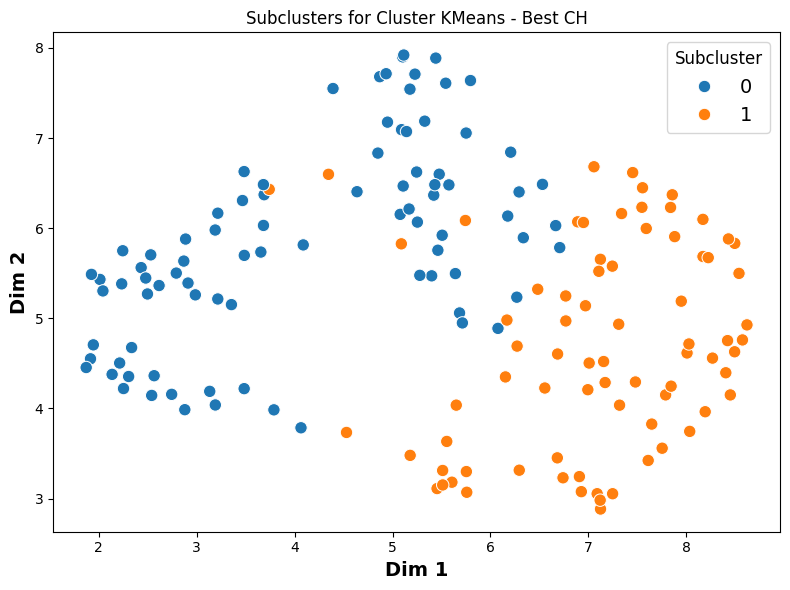

Best SIL for KMeans is from parent cluster 58 with score 0.25


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


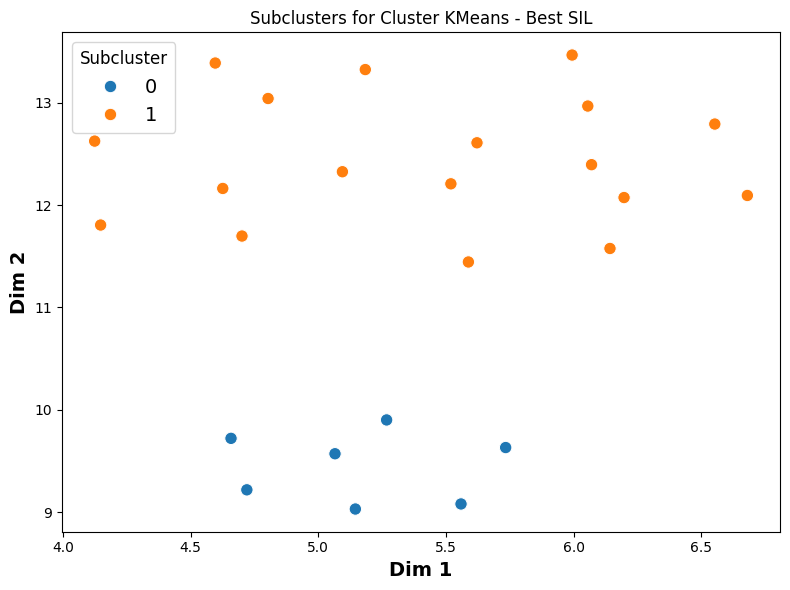

Best DBI for KMeans is from parent cluster 58 with score 1.28


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


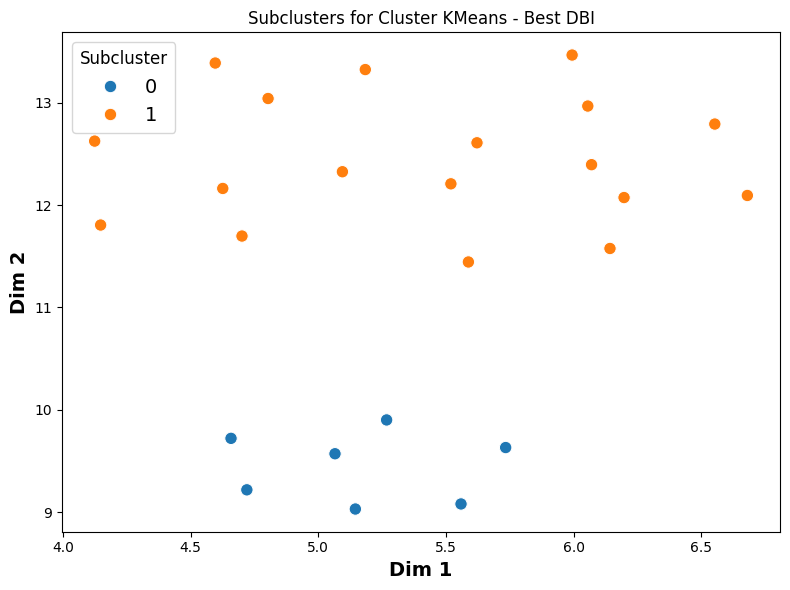

Best CH for BIRCH is from parent cluster 5 with score 25.52


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


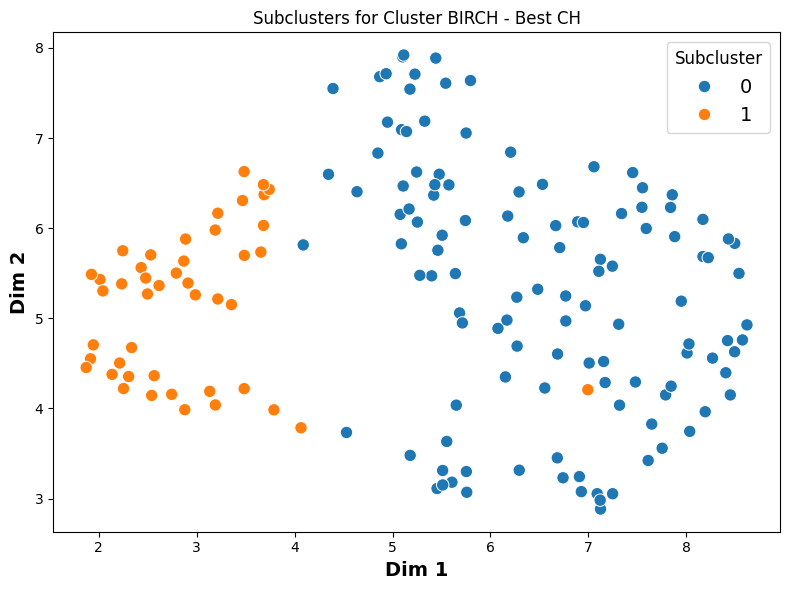

Best SIL for BIRCH is from parent cluster 58 with score 0.25


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


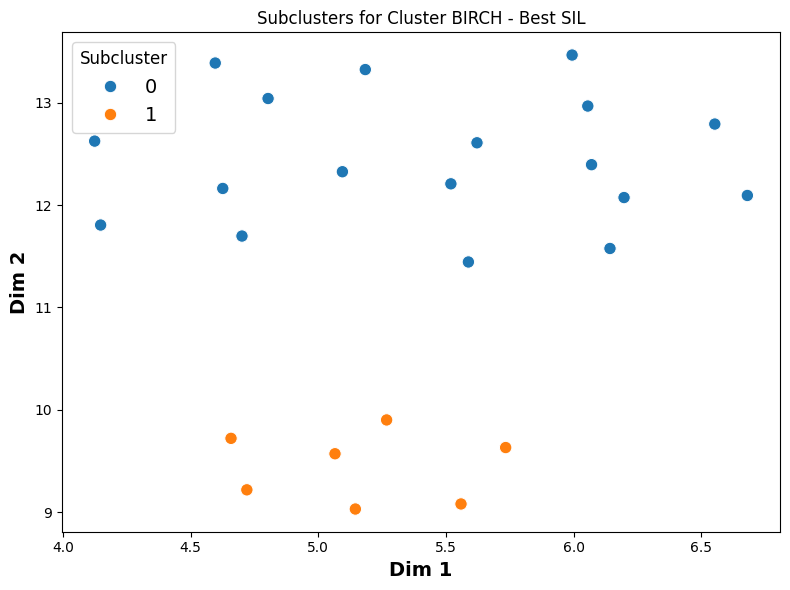

Best DBI for BIRCH is from parent cluster 58 with score 1.28


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


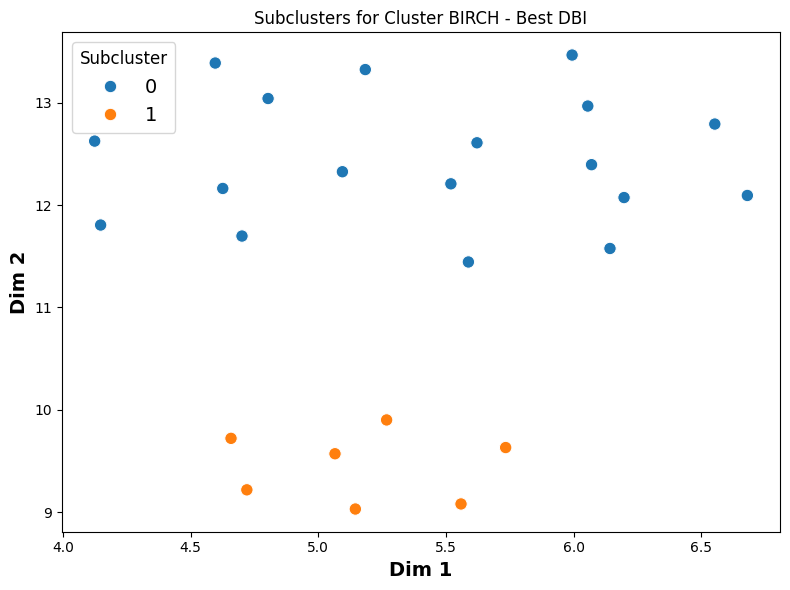

Best CH for Agglomerative is from parent cluster 2 with score 22.42


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


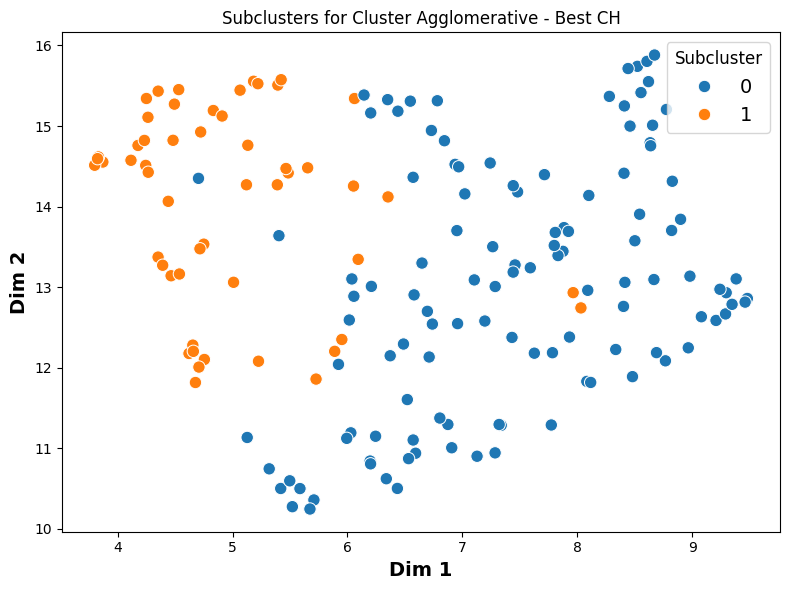

Best SIL for Agglomerative is from parent cluster 58 with score 0.25


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


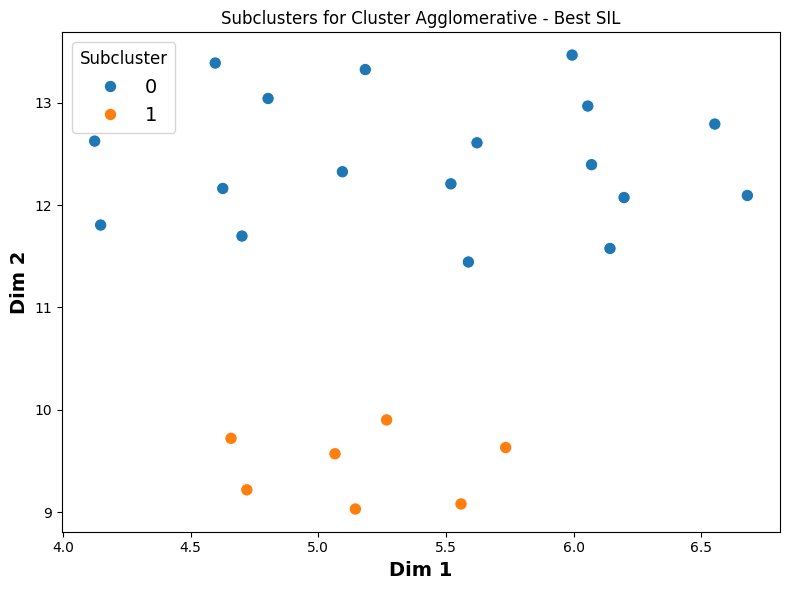

Best DBI for Agglomerative is from parent cluster 58 with score 1.28


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


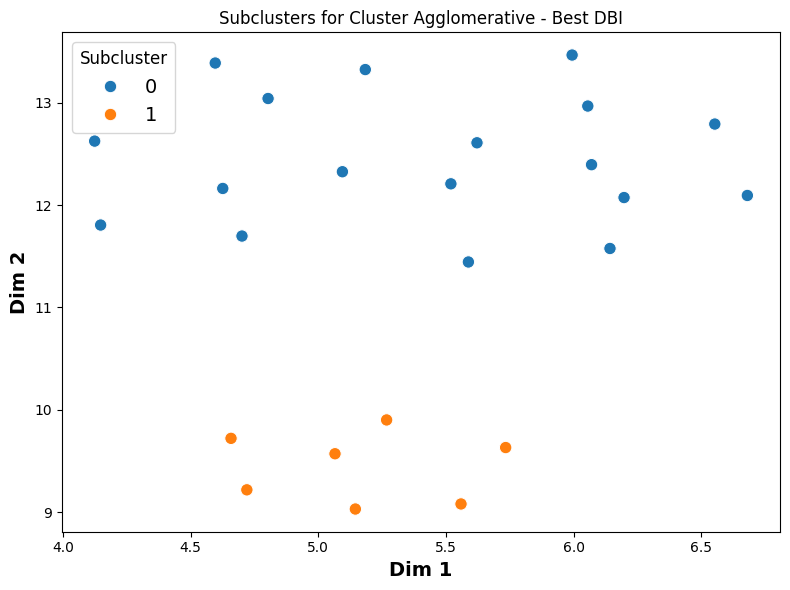

In [34]:
# Visualizes the top subclusters with the best metrics per clustering algorithm
for method, metrics in best_clusters.items():
    for metric, info in metrics.items():
        print(f"Best {metric.upper()} for {method} is from parent cluster {info['cluster_id']} with score {info['score']:.2f}")
        visualize_subclusters(info['embeddings'], info['labels'], f"{method} - Best {metric.upper()}")


## **Compare Clustering Methods with Raw Scores**
- Use boxplots to compare distribution of CH, Silhouette, and DBI across all methods.

In [35]:
results_df = pd.DataFrame(all_scores) # Convert the scores for each parent cluster into a dataframe for later visualization

In [36]:
results_df.head()

,cluster,method,k,ch_score,sil_score,dbi_score
0,4,KMeans,4,24.741980,0.141349,2.024405
1,4,BIRCH,4,16.939816,0.086827,2.496327
2,4,Agglomerative,3,20.473375,0.117858,2.371955
3,2,KMeans,3,26.044521,0.141635,2.093500
4,2,BIRCH,3,21.096212,0.112054,2.361460


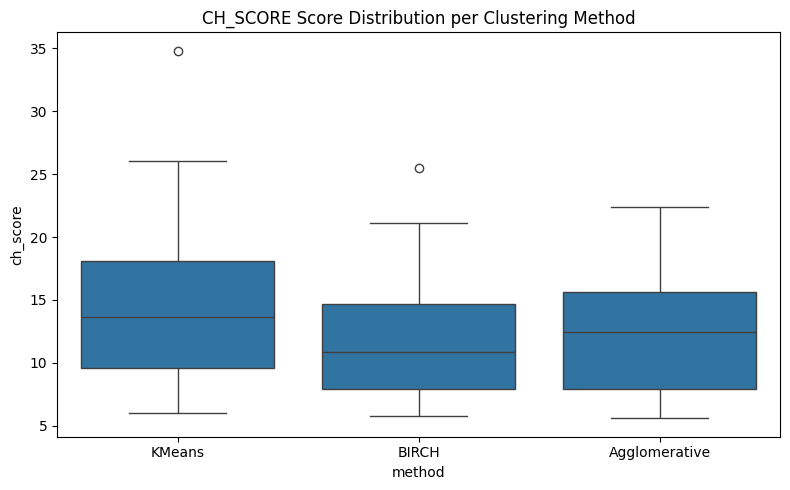

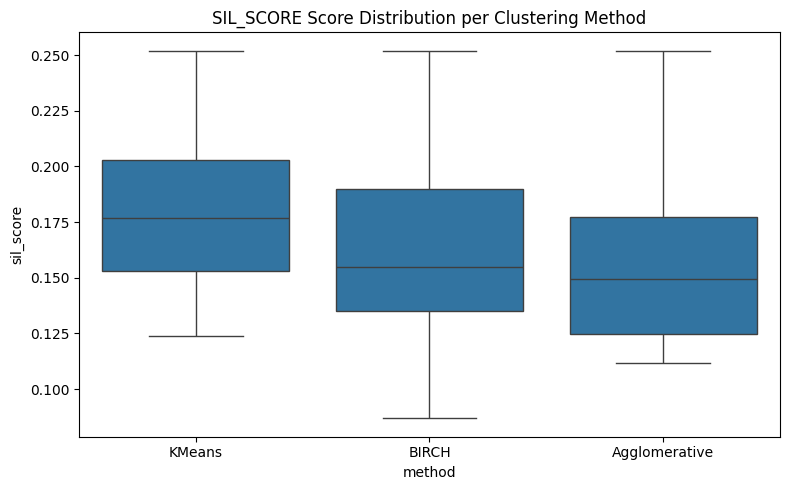

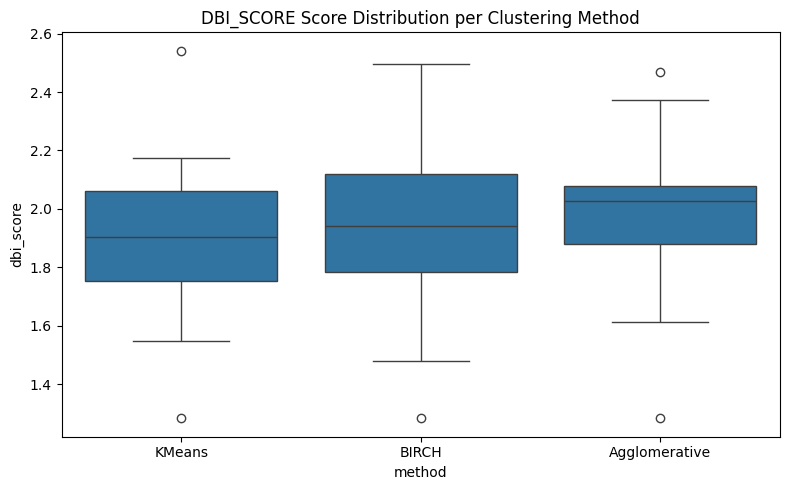

In [37]:
metrics = ['ch_score', 'sil_score', 'dbi_score']
for metric in metrics:
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=pd.DataFrame(all_scores), x='method', y=metric)
    plt.title(f'{metric.upper()} Score Distribution per Clustering Method')
    plt.tight_layout()
    plt.show()


## **Standardized Metric Comparison (Z-Score Analysis)**
- Normalize scores and visualize performance across methods using Z-scores

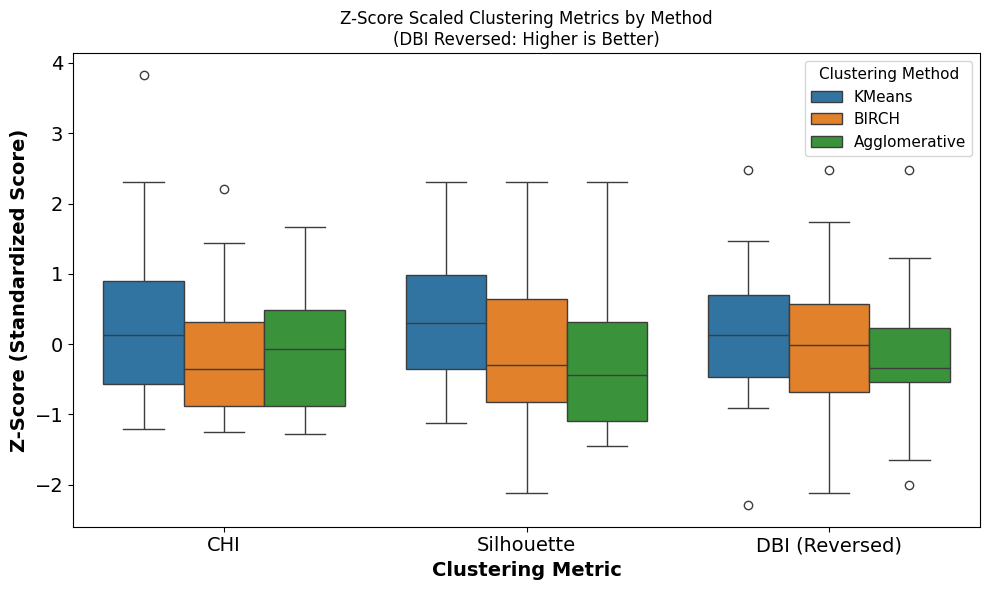

In [48]:
# Rename metrics for clarity
metric_labels = {
    "ch_score": "CHI",
    "sil_score": "Silhouette",
    "dbi_score": "DBI (Reversed)"
}


# Melt the DataFrame
melted = results_df.melt(
    id_vars=["cluster", "method"],
    value_vars=["ch_score", "sil_score", "dbi_score"],
    var_name="Metric",
    value_name="Score"
)

# Invert DBI scores (lower is better → higher is better for visualization)
melted.loc[melted["Metric"] == "dbi_score", "Score"] *= -1

# Map renamed labels
melted["Metric"] = melted["Metric"].map(metric_labels)

# Apply Z-score scaling within each metric
melted["Scaled_Score"] = melted.groupby("Metric")["Score"].transform(
    lambda x: StandardScaler().fit_transform(x.values.reshape(-1, 1)).flatten()
)

# Plot the scaled scores
plt.figure(figsize=(10, 6))
sns.boxplot(data=melted, x="Metric", y="Scaled_Score", hue="method")
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("Z-Score Scaled Clustering Metrics by Method\n(DBI Reversed: Higher is Better)")
plt.ylabel("Z-Score (Standardized Score)", fontsize=14, fontweight="bold")
plt.xlabel("Clustering Metric", fontsize=14, fontweight="bold")
plt.legend(title="Clustering Method", title_fontsize=11, fontsize=11)
plt.tight_layout()
plt.show()

## **Clustering Method Selection Summary**

**K-Means** consistently outperformed **BIRCH** and **Agglomerative Clustering** across all evaluation metrics:

- **Calinski-Harabasz Index (CHI)**: Highest median  
- **Silhouette Score**: Highest median  
- **Reversed Davies-Bouldin Index (DBI)**: Highest median and narrowest IQR  
- **Stability**: Highest overall IQR values, indicating more consistent performance

### **Key Highlights**
- K-Means produced **more consistent subclusters** within the interquartile range (IQR)
- **Agglomerative Clustering** exhibited the **widest DBI and Silhouette range**, indicating higher variability
- **K-Means was selected** as the final subclustering method
- Its top-performing parent cluster showed **strong cohesion and separation** (see best DBI visualization below)

✅ *These results support K-Means as the most stable and reliable method for subclustering in this analysis.*


## **Print Sample Issues Summaries from Best DBI (KMeans)**
- Show summaries grouped by subcluster from the parent cluster with the best KMeans DBI Score.

In [ ]:
# Assign best DBI KMeans labels back to df_merged
for method in best_clusters:
    if 'dbi' in best_clusters[method] and method == 'KMeans':
        cluster_id = best_clusters[method]['dbi']['cluster_id']
        labels = best_clusters[method]['dbi']['labels']

        # Update the relevant portion of df_merged
        df_merged.loc[df_merged['cluster'] == cluster_id, 'subcluster_KMeans_dbi'] = labels


In [ ]:
print("\n=== ISSUE SUMMARIES FOR BEST DBI (KMeans) ONLY ===")

cluster_id = best_clusters['KMeans']['dbi']['cluster_id']
if cluster_id is not None:
    cluster_data = df_merged[df_merged['cluster'] == cluster_id]

    for subcluster_id in sorted(cluster_data['subcluster_KMeans_dbi'].dropna().unique()):
        print(f"\n--- Parent Cluster {cluster_id} | Subcluster {int(subcluster_id)} ---")
        subcluster_rows = cluster_data[cluster_data['subcluster_KMeans_dbi'] == subcluster_id]

        for i, summary in enumerate(subcluster_rows['issue_summary'], 1):
            print(f"{i}. {summary}")



=== ISSUE SUMMARIES FOR BEST DBI (KMeans) ONLY ===

--- Parent Cluster 58 | Subcluster 0 ---
1. The user is encountering an issue with CellBender and CUDA on the Bell server while trying to run an analysis on GPU nodes. The error message suggests that CUDA is not available on Bell-G nodes because they are equipped with AMD GPUs.
2. Students cannot run the latest ML methods in Gilbreth cluster due to an old CUDA version.
3. User requires cuDNN version 8.9.7 compatible with CUDA 12.x on the Gilbreth system due to specific jax packages.
4. User wants to update CUDA version from 11.0 to 12.0 on HPC system Gilbreth for running Pytorch 2.1.
5. User needs assistance in using CUDA version 11.3 on Gilbreth cluster.
6. Request to update CUDA versions on Gilbreth cluster from 12.1 to 12.4 and 12.8 for better software compatibility and access to newer features. Additionally, an upgrade of glibc was requested to version 2.28 for improved compatibility with essential libraries such as RDKit.
7. Use